# Experiment 3 - Probabilities and Uncertainty

## Prepare Notebook

In [1]:
import os
import sys
import logging
import warnings

warnings.filterwarnings("ignore")

INSTALL_DEPS = True
if INSTALL_DEPS:
    %pip install yfinance==0.2.43
    %pip install openai==1.51.2

%load_ext dotenv

FUNDAMENTALS_PATH = os.getenv("FUNDAMENTALS_PATH")
LLM_PROMPTS_PATH = os.getenv("LLM_PROMPTS_PATH")
FUNDAMENTALS_PATH = os.getenv("FUNDAMENTALS_PATH")
HISTORIC_PATH = os.getenv("HISTORIC_PATH")
MACRO_PATH = os.getenv("MACRO_PATH")
OPTIONS_PATH = os.getenv("OPTIONS_PATH")
LLM_OUTPUT_PATH = os.getenv("LLM_OUTPUT_PATH")
LOGS_PATH = os.getenv("LOGS_PATH")
paths = [LLM_OUTPUT_PATH, LOGS_PATH]
for path in paths:
    if path and not os.path.exists(path):
        os.makedirs(path)

if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    logging.info("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    DATA_PATH = "/kaggle/input/drl-dataset-quant"
    FUNDAMENTALS_PATH = DATA_PATH + FUNDAMENTALS_PATH
    HISTORIC_PATH = DATA_PATH + HISTORIC_PATH
    MACRO_PATH = DATA_PATH + MACRO_PATH
    OPTIONS_PATH = DATA_PATH + OPTIONS_PATH

    sys.path.insert(1, "/kaggle/usr/lib/drlutil")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yaml
import math
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from openai import OpenAI

module_path = os.path.abspath(os.path.join(os.getcwd(), 'utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data_utils import generate_strategy_for_ticker, evaluate_trading_metrics, PERSONA, HIGH_RISK_PROFILE, HIGH_OBJECTIVES

## Environment and Constants

In [3]:
# A lot of ranging in these dates across the market.
START_DATE = '20180501'
END_DATE = '20181101'
TARGET = "TSLA"
OPENAI_MODEL = os.getenv("OPENAI_MODEL")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [4]:
output_file = f"{HISTORIC_PATH}/engineered_{TARGET}_data.parquet"
stock_aug_data = pd.read_parquet(output_file)
stock_aug_data['Date'] = pd.to_datetime(stock_aug_data['Date'], utc=True)  # Ensure Date is timezone-aware
stock_aug_data.set_index('Date', inplace=True)

sample_start_date = pd.Timestamp(START_DATE, tz='UTC')  # Ensure timezone-awareness
sample_end_date = pd.Timestamp(END_DATE, tz='UTC')

stock_aug_data = stock_aug_data.loc[sample_start_date:sample_end_date]
stock_aug_data.tail(1)


,Open,High,Low,Close,Volume,IV_Open,IV_High,IV_Low,IV_Close,IV_Volume,...,Volume_Weighted_Returns,BB_Upper,BB_Middle,BB_Lower,BB_Width,IV_Percentile,VIX_Impact,Momentum_Long,Momentum_Short,content
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-01 00:00:00+00:00,22.92,23.28,22.73,23.09,21394755.0,0.524065,0.53024,0.503397,0.509127,1.0,...,265695.506336,23.377978,22.568,21.758022,0.070158,0.0,-24.166188,True,False,"[, , , , , , ]"


# Probabilities Loop

In [5]:
OPENAI_CLIENT = OpenAI(api_key=OPENAI_API_KEY)

# Calculate Probabilities

OpenAI cookbook [here](https://cookbook.openai.com/examples/using_logprobs).

In [6]:
STARTDATE = '2012-01-01'
SPLITDATE = '2018-01-01'
ENDDATE = '2020-01-01'

stock_aug_data = generate_strategy_for_ticker(ticker_df=stock_aug_data,
                                            ticker=TARGET,
                                            LLM_OUTPUT_PATH=f'{LLM_OUTPUT_PATH}/r/v5/',
                                            persona=PERSONA,
                                            HIGH_RISK_PROFILE=HIGH_RISK_PROFILE,
                                            HIGH_OBJECTIVES=HIGH_OBJECTIVES,
                                            client=OPENAI_CLIENT,
                                            model=OPENAI_MODEL,
                                            strategy_yaml_file=f'{LLM_PROMPTS_PATH}/strat_prompt_v5.yml',
                                            eval_yaml_file=f'{LLM_PROMPTS_PATH}/evaluator_prompt_v2.yml',
                                            news_yaml_file=f'{LLM_PROMPTS_PATH}/news_analyst_prompt_v1.yml',
                                            start_date=STARTDATE,
                                            end_date=ENDDATE,
                                            max_news=0)
_, stock_aug_data = evaluate_trading_metrics(stock_aug_data)
stock_aug_data.sample(1)


Generating strategies for TSLA:   0%|          | 0/130 [00:00<?, ?it/s]

,Open,High,Low,Close,Volume,IV_Open,IV_High,IV_Low,IV_Close,IV_Volume,...,Lagged_Position,Daily_Returns,Sharpe_Ratio,Absolute_Position_Change,Portfolio_Turnover,Cumulative_Wealth,Drawdown,Max_Drawdown,Mean_Drawdown_Duration,Cumulative_Returns
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-16 00:00:00+00:00,20.59,21.64,20.59,21.51,19419300.0,0.56845,0.571228,0.546147,0.546353,1.0,...,-1.0,-0.040639,0.636323,0.0,2.0,0.891424,0.178069,0.331776,51.902439,0.121632


In [7]:
def plot_strategy_evolution_with_cumulative_returns(df):
    # Convert log probabilities to probabilities
    log_prob_columns = ['long_token', 'short_token', 'long_token_proba', 'short_token_proba']
    for col in log_prob_columns:
        df[col] = np.exp(df[col])

    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
    plt.subplots_adjust(hspace=0.4)

    # Plot 1: Log returns per month with cumulative returns as a secondary y-axis
    ax1 = axes[0]
    ax2 = ax1.twinx()
    ax1.plot(df.index, df['Cumulative_Wealth'], label="Cumulative Returns",  color='blue')
    ax2.plot(df.index, df['Close'], label="Close", color='orange', alpha=0.7)
    ax1.set_title("Returns")
    ax2.set_ylabel("Close")
    ax1.set_ylabel("Cumulative Returns")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    # Plot 2: Token Probabilities (converted from log probabilities)
    axes[1].plot(df.index, df['long_token'], label="Long Token Probability", alpha=0.7)
    axes[1].plot(df.index, df['short_token'], label="Short Token Probability", alpha=0.7)
    axes[1].plot(df.index, df['long_token_proba'], label="Long Token Proba", alpha=0.7)
    axes[1].plot(df.index, df['short_token_proba'], label="Short Token Proba", alpha=0.7)
    axes[1].set_ylabel("Probability")
    axes[1].set_title("Token Probabilities")
    axes[1].legend()

    # Plot 3: Long and Short Probabilities
    axes[2].plot(df.index, df['long_conf_score'], label="Long Probability", alpha=0.7)
    axes[2].plot(df.index, df['short_conf_score'], label="Short Probability", alpha=0.7)
    axes[2].set_title("Long and Short Probabilities")
    axes[2].set_ylabel("Probability")
    axes[2].legend()

    # Plot 4: Perplexity and Entropy
    ax1 = axes[3]
    ax2 = ax1.twinx()
    ax1.plot(df.index, df['perplexity'], label="Perplexity", alpha=0.7, color='purple')
    ax2.plot(df.index, df['entropy'], label="Entropy", alpha=0.7, color='red')
    ax1.set_title("Uncertainty Over Time")
    ax1.set_ylabel("Perplexity")
    ax2.set_ylabel("Entropy")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.xlabel("Date")
    plt.show()


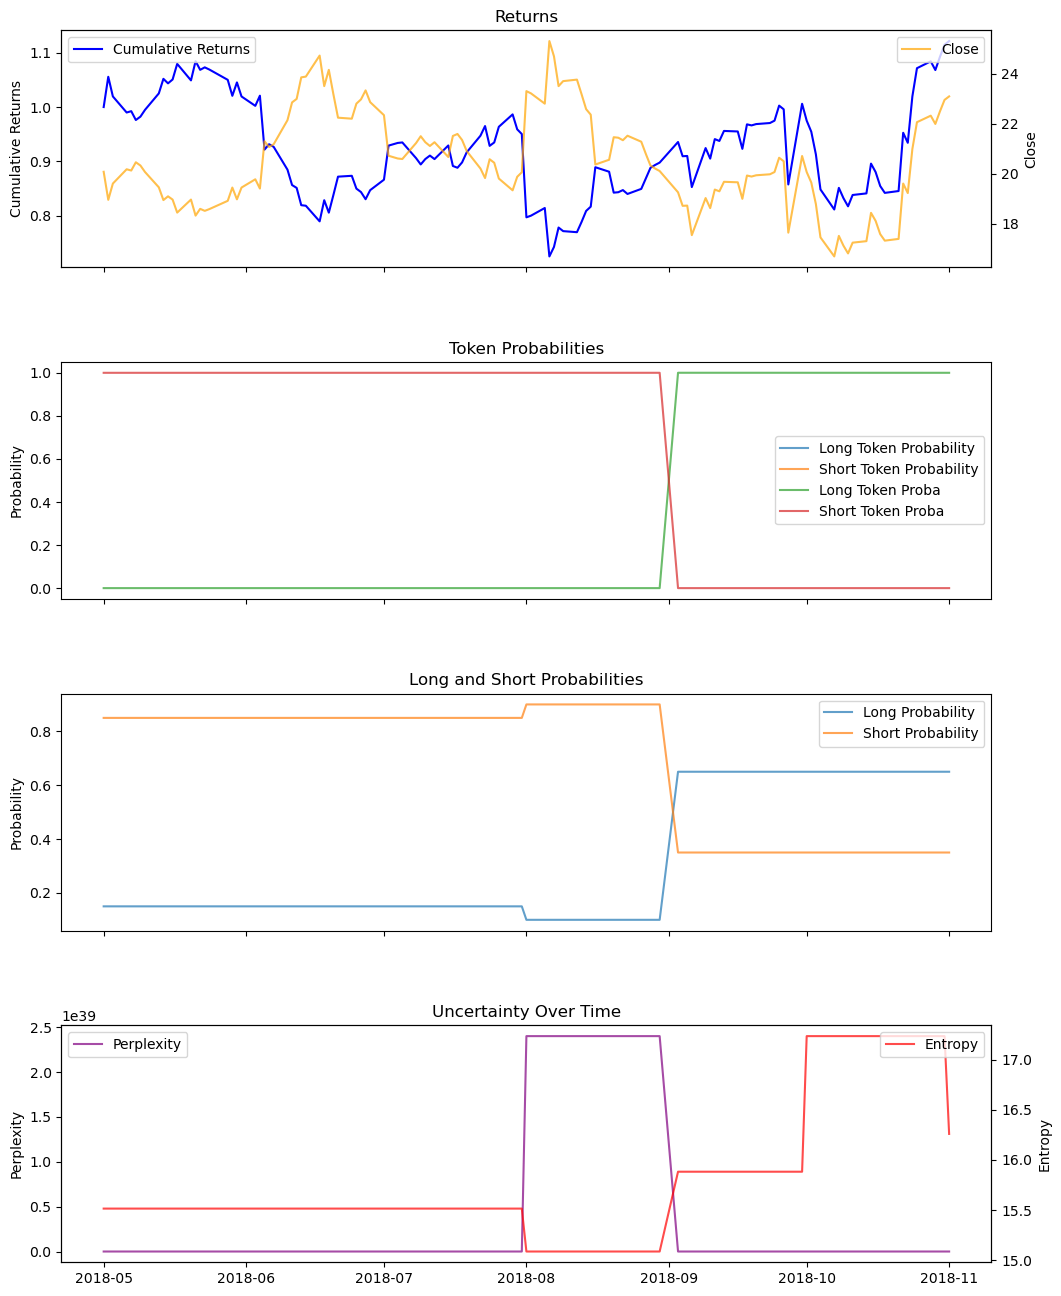

In [8]:
plot_strategy_evolution_with_cumulative_returns(stock_aug_data)